In [1]:
# Some of the starting code for face attribute detection is
# adapted from https://github.com/Luca96/face-clustering/

In [2]:
import os
import cv2    
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from keras.models import Model, Sequential
from keras.layers import Dropout, Dense, BatchNormalization, Reshape
from keras.callbacks import ModelCheckpoint
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import keras.optimizers

# make inline plots larger
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 160

Using TensorFlow backend.


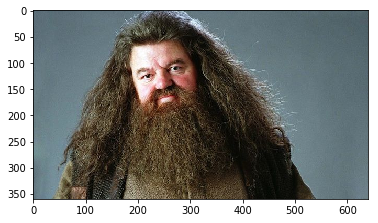

In [3]:
def imread(pic_path):
    pic = cv2.imread(pic_path)
    pic = cv2.cvtColor(pic, cv2.COLOR_BGR2RGB)

    plt.imshow(pic)
    plt.show()

# Verify functionality
imread("../new_beards/beards/celeb/Hagrid/beard/hagrid beard 1.jpg")

In [4]:
# Load pre-trained face feature detection model
model = keras.models.load_model("face-clustering/weights/weights-FC37-MobileNetV2-0.92.hdf5")







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [5]:
# Check model is properly loaded
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

In [6]:
# Model Input Image Format
img_size = 224

# default is 224
IMG_W = img_size
IMG_H = img_size
IMG_SHAPE = (IMG_H, IMG_W, 3)
TARGET_SIZE = (IMG_H, IMG_W)

In [7]:
# We'll demonstrate performance of this network by running it
# on some sample images
features_names = "5_o_Clock_Shadow Arched_Eyebrows Bags_Under_Eyes Bald Bangs Big_Lips Big_Nose Black_Hair Blond_Hair Brown_Hair Bushy_Eyebrows Chubby Double_Chin Eyeglasses Goatee Gray_Hair Heavy_Makeup High_Cheekbones Male Mouth_Slightly_Open Mustache Narrow_Eyes No_Beard Oval_Face Pointy_Nose Receding_Hairline Rosy_Cheeks Sideburns Smiling Straight_Hair Wavy_Hair Wearing_Earrings Wearing_Hat Wearing_Lipstick Wearing_Necklace Wearing_Necktie Young".split()

In [8]:

# ------------------------------------------------------------------------------
# -- Maps: feature_name -> index, and index -> feature_name
# ------------------------------------------------------------------------------

dict_feature_name_to_index = { name: i for i, name in enumerate(features_names) }
dict_index_to_feature_name = { v: k for k, v in dict_feature_name_to_index.items() }

def features_to_indexes(features_name):
  '''From a feature_name returns an index.
     Example: 'Bangs' -> 4
  '''
  indexes = []
  
  for name in features_name:
    indexes.append(dict_feature_name_to_index[name])
  
  return indexes


def indexes_to_features(feature_indexes):
    '''From a feature_index returns its name.
       Example: 4 -> 'Bangs'
    '''
    features_name = []

    for index in feature_indexes:
        features_name.append(dict_index_to_feature_name[index])

    return features_name

In [9]:
def image_paths_from_folder(folder, amount=-1):
    '''From a given folder returns an array of images' path.
       Set amount > 0 to limit the number of path taken.

       Supports images with extendsion: '.jpeg', '.jpg' and '.png'
    '''
    assert(folder is not None)

    paths = []
    count = 0
  
    for file in os.listdir(folder):
        # select only images
        if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.png'):
            paths.append(os.path.join(folder, file))
            count += 1

            if count == amount:
                break
    
    return paths

def load_reshape_img(fname, shape):
    img = load_img(fname, target_size=shape)
    x = img_to_array(img) / 255.0
    x = x.reshape(x.shape)
    return x


def infere_labels(model, paths):
    '''Use the given model to predict the images features.
       The images are loaded from the given paths.

       Returns an array of array of features.
    '''
    assert(model is not None)
    # first load images
    image_batch = []

    for path in paths:
        img = load_reshape_img(path, TARGET_SIZE)
        image_batch.append(img)
    
    # predict labels: batch_size will handle large amount of images
    preds = model.predict(np.array(image_batch), batch_size=64, verbose=1)

    # convert labels to 0, 1 integers.
    preds = np.round(preds).astype('int')  
    return preds

def dataframe_from_folder_or_labels(features_name, folder, labels=None, model=None, amount=-1):
    '''Organize images and feature-labes in a DataFrame.
       - If labels are given it will take that instead, it uses the model to 
         infere the images's labels.
       - Use amount to limit the number of images (and so predictions)

     Returns a pandas data-frame indexed by 'image_path'.
    '''
    paths = image_paths_from_folder(folder, amount)
    labels = labels or infere_labels(model, paths)
    indexes = features_to_indexes(features_name)

    df = pd.DataFrame()
    df['image_path'] = paths
    df.set_index('image_path', inplace=True)

    # select features for every image
    for i, name in enumerate(features_name):
        column = []

        for j, features in enumerate(labels):
            column.append(features[indexes[i]])
        df[name] = column
  
    # take features
    img_features = []
    for features in labels:
        features_ = []
    
        for i, name in enumerate(features_name):
            features_.append(features[indexes[i]])
        img_features.append(features_)
  
    # set a column with the selected features
    df['features'] = img_features

    return df

In [10]:
chosen_features = [
    'Smiling',               
    'No_Beard',      
    'Bald',
    'Male',           
    '5_o_Clock_Shadow',
    'Chubby',
    'Double_Chin',
    'Wearing_Hat',
    'Mustache',
    'Rosy_Cheeks',
    'Sideburns',
]
dataframe_from_folder_or_labels(chosen_features, "../new_beards/beards/celeb/Hagrid/beard/",  model=model)

10/10 [==============================] - 2s 185ms/step


,Smiling,No_Beard,Bald,Male,5_o_Clock_Shadow,Chubby,Double_Chin,Wearing_Hat,Mustache,Rosy_Cheeks,Sideburns,features
image_path,,,,,,,,,,,,
../new_beards/beards/celeb/Hagrid/beard/hagrid beard 8.jpg,0,0,0,1,0,1,1,1,1,0,1,"[0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1]"
../new_beards/beards/celeb/Hagrid/beard/hagrid beard 5.jpg,0,0,0,1,0,0,0,1,0,0,0,"[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]"
../new_beards/beards/celeb/Hagrid/beard/hagrid beard 3.png,0,0,0,1,0,0,0,0,0,0,0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
../new_beards/beards/celeb/Hagrid/beard/hagrid beard 1.jpg,0,0,0,1,0,0,0,0,0,0,0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
../new_beards/beards/celeb/Hagrid/beard/hagrid beard 10.jpg,0,0,0,1,0,0,0,0,0,0,1,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1]"
../new_beards/beards/celeb/Hagrid/beard/hagrid beard 6.jpg,0,0,0,1,0,0,0,0,0,0,0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
../new_beards/beards/celeb/Hagrid/beard/hagrid beard 4.jpg,0,0,0,1,0,0,0,0,0,0,0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
../new_beards/beards/celeb/Hagrid/beard/hagrid beard 9.jpg,0,0,0,1,0,0,0,0,0,0,0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
../new_beards/beards/celeb/Hagrid/beard/hagrid beard 7.jpg,0,0,0,1,0,0,0,0,0,0,0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"


In [11]:
def load_reshape_img(path, shape=IMG_SHAPE):
        img = load_img(path, target_size=shape)
        img = img_to_array(img) / 255.0
#         x = x.reshape((1, ) + x.shape)
        return img

def load_folder(folder_path):
    
    beardpath = os.path.join(folder_path, "beard")
    nobeardpath = os.path.join(folder_path, "no_beard")
    
    x = []
    y = []
    
    print("Checking", beardpath)
    # Load pictures with beards
    paths = image_paths_from_folder(beardpath)
    for i, path in enumerate(paths):
        img = load_reshape_img(path, TARGET_SIZE)
        x.append(img)
        y.append(1) # 1 = beard

    print("Checking", nobeardpath)
    # Load pictures without beards
    paths = image_paths_from_folder(nobeardpath)
    for i, path in enumerate(paths):
        img = load_reshape_img(path, TARGET_SIZE)
        x.append(img)
        y.append(0) # 0 = no beard
        
    return np.asarray(x), np.asarray(y)

# Load data
def load_beard_data(data_path):
    
    all_x = None
    all_y = None
    
    for folder in os.listdir(data_path):
        # Check that it is a folder and not a hidden folder like .git
        if os.path.isdir(os.path.join(data_path, folder)) and folder[0] != ".":
            x, y = load_folder(os.path.join(data_path, folder))
        
            if all_x is None:
                all_x = x
                all_y = y
            else:
                all_x = np.concatenate((all_x, x))
                all_y = np.concatenate((all_y, y))
            
    return np.asarray(all_x), np.asarray(all_y)

In [12]:
# Create our beard detection model by transfer learning from
# the pretrained feature detection model
def hagridenet_model(num_features):
    # Transfer learning from exsiting model
    base = model
    
    # Make all existing layers non-trainable
    for layer in base.layers:
        layer.trainable = False

    # Chop off parts of model not from mobilenet
    x = base.layers[-5].output
    
    # Add new, trainable layers with regularization
    x = Dense(500, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    x = Dense(500, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    top = Dense(num_features, activation='sigmoid')(x)
    
    return Model(inputs=base.input, outputs=top)

def logistic_model():
    layer = Sequential()
    layer.add(Reshape((224*224*3,), input_shape=(224,224,3)))
    layer.add(Dense(1, activation='sigmoid'))
    return layer

In [13]:
hagrid = hagridenet_model(1) # Only 1 feature (beard vs no beard)
hagrid.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

In [14]:
logistic = logistic_model()
logistic.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 150528)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 150529    
Total params: 150,529
Trainable params: 150,529
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Training Parameters
batch_size = 64
num_epochs = 12

In [16]:
# Load data
celeb_x, celeb_y = load_beard_data("../new_beards/beards/celeb")
misc_x, misc_y = load_folder("../new_beards/beards/misc")

Checking ../new_beards/beards/celeb/Jamie Dornan/beard
Checking ../new_beards/beards/celeb/Jamie Dornan/no_beard
Checking ../new_beards/beards/celeb/Jake Gyllenhal/beard
Checking ../new_beards/beards/celeb/Jake Gyllenhal/no_beard
Checking ../new_beards/beards/celeb/Johnny Galecki/beard
Checking ../new_beards/beards/celeb/Johnny Galecki/no_beard
Checking ../new_beards/beards/celeb/David Schwimmer/beard
Checking ../new_beards/beards/celeb/David Schwimmer/no_beard
Checking ../new_beards/beards/celeb/Antonio_Banderas/beard
Checking ../new_beards/beards/celeb/Antonio_Banderas/no_beard
Checking ../new_beards/beards/celeb/Harrison Ford/beard
Checking ../new_beards/beards/celeb/Harrison Ford/no_beard
Checking ../new_beards/beards/celeb/Mel Gibson/beard
Checking ../new_beards/beards/celeb/Mel Gibson/no_beard
Checking ../new_beards/beards/celeb/John Krasinski/beard
Checking ../new_beards/beards/celeb/John Krasinski/no_beard
Checking ../new_beards/beards/celeb/Shia Labeouf/beard
Checking ../new_b

In [17]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [18]:
# Shuffle data
celeb_x, celeb_y = unison_shuffled_copies(celeb_x, celeb_y)
misc_x, misc_y = unison_shuffled_copies(misc_x, misc_y)

# take 200 from misc for test set
test_size = 200
test_x, test_y = misc_x[:test_size], misc_y[:test_size]
train_x, train_y = np.concatenate((celeb_x, misc_x[test_size:])), np.concatenate((celeb_y, misc_y[test_size:]))


In [19]:
train_y.shape

(3043,)

In [20]:
np.mean(test_y)

0.475

In [21]:
# Create data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=20, 
    rescale=1./255, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True, 
    fill_mode='nearest')

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
# datagen.fit(x_train)

# fits the model on batches with real-time data augmentation:
# model.fit_generator(datagen.flow(x_train, y_train, batch_size=32),
#                     steps_per_epoch=len(x_train) / 32, epochs=epochs)

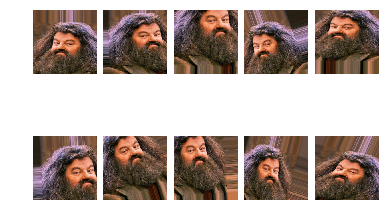

In [22]:
def load_reshape_img(path, shape=IMG_SHAPE):
    img = load_img(path, target_size=shape)
    x = img_to_array(img) / 255.0
    x = x.reshape((1, ) + x.shape)
    return x

# Demonstrate data augmentation
sample = load_reshape_img("../new_beards/beards/celeb/Hagrid/beard/hagrid beard 4.jpg")

for i, image in enumerate(datagen.flow(sample, batch_size=1)):
    if i == 10:
        break

    plt.subplot(2, 5, i + 1)
    plt.grid(False)
    plt.axis('off')
#     plt.subplots_adjust(wspace=0.1, hspace=0.1, top=0.2, right=0.2)
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.1)
    plt.imshow(image.reshape(IMG_SHAPE) * 255.)

_ = plt.show()

In [27]:
# ------------------------------------------------------------------------------
# -- Compile model
# ------------------------------------------------------------------------------


adam = keras.optimizers.Adam(lr=0.0001)                
hagrid.compile(loss='binary_crossentropy', #cosine_proximity
              optimizer=adam,
              metrics=['binary_accuracy'])

sgd = keras.optimizers.SGD(lr=0.0001)#, decay=1e-8)
logistic.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['binary_accuracy'])

In [28]:
# ------------------------------------------------------------------------------
# -- Checkpointing: at each epoch, the best model so far is saved
# ------------------------------------------------------------------------------

# model_path = f"{save_path}/UL19/weights-FC37-MobileNetV2-" + "{val_binary_accuracy:.2f}.hdf5"
model_path = f"saved_models/beard-all-weights-" + "{val_binary_accuracy:.2f}.hdf5"

checkpoint = ModelCheckpoint(
    model_path,
    monitor='val_binary_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [29]:
# for layer in hagrid.layers:
#     layer.trainable = True

In [30]:
# Training Parameters
batch_size = 64
num_epochs = 20

# Fits the model on batches with real-time data augmentation:
history = hagrid.fit_generator(
    datagen.flow(train_x, train_y, batch_size=batch_size),
    steps_per_epoch = len(train_x) / batch_size,
    epochs=num_epochs,
    validation_data=(test_x,test_y),
    max_queue_size=1,
    shuffle=True,
    callbacks=[checkpoint],
    verbose=1
)

Epoch 1/20
48/47 [==============================] - 216s 5s/step - loss: 0.1224 - binary_accuracy: 0.9613 - val_loss: 0.1357 - val_binary_accuracy: 0.9500

Epoch 00001: val_binary_accuracy improved from -inf to 0.95000, saving model to saved_models/beard-all-weights-0.95.hdf5
Epoch 2/20
48/47 [==============================] - 211s 4s/step - loss: 0.0930 - binary_accuracy: 0.9672 - val_loss: 0.1289 - val_binary_accuracy: 0.9550

Epoch 00002: val_binary_accuracy improved from 0.95000 to 0.95500, saving model to saved_models/beard-all-weights-0.95.hdf5
Epoch 3/20
48/47 [==============================] - 211s 4s/step - loss: 0.0889 - binary_accuracy: 0.9713 - val_loss: 0.1411 - val_binary_accuracy: 0.9450

Epoch 00003: val_binary_accuracy did not improve from 0.95500
Epoch 4/20
48/47 [==============================] - 215s 4s/step - loss: 0.0646 - binary_accuracy: 0.9779 - val_loss: 0.1403 - val_binary_accuracy: 0.9600

Epoch 00004: val_binary_accuracy improved from 0.95500 to 0.96000, sa

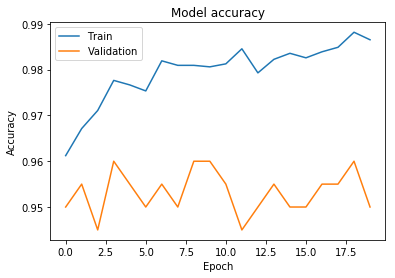

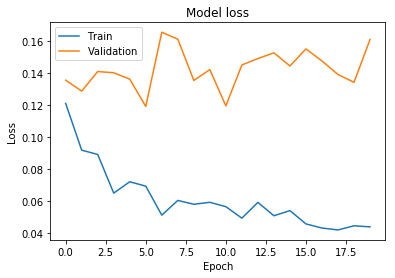

In [31]:
def plot_model_history(history):
  '''plots useful graphs about the model training: loss, accuracy, ecc.'''
  plt.plot(history.history['binary_accuracy'])
  plt.plot(history.history['val_binary_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

  
# plot the training and validation loss for every epoch:
plot_model_history(history)

In [37]:
x_train_reshaped = train_x.reshape(train_x.shape[0],-1)
# test = x_train_reshaped[:100]

In [32]:
# test.shape

(100, 150528)

In [48]:
from sklearn import datasets, svm
from sklearn.svm import LinearSVC, SVC
from sklearn.kernel_approximation import Nystroem
clf = svm.SVC()
feature_map_nystroem = Nystroem(gamma=.2,
                                random_state=1,
                                n_components=1000)
data_transformed = feature_map_nystroem.fit_transform(x_train_reshaped)
clf.fit(data_transformed, train_y)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [49]:
test_x_transform = feature_map_nystroem.transform(test_x.reshape(test_x.shape[0],-1))
clf.score(test_x_transform, test_y)

0.53

In [266]:
x_train.reshape(x_train.shape[0],-1).shape

(2243, 150528)

In [31]:
x_train_reshaped.shape

NameError: name 'x_train_reshaped' is not defined

In [199]:
pred = hagrid.predict(x_test) > 0.5

In [204]:
np.nonzero(pred - y_test)

(array([  3,  33,  34,  65, 105, 106]), array([0, 0, 0, 0, 0, 0]))

In [214]:
pred[105]

array([ True])

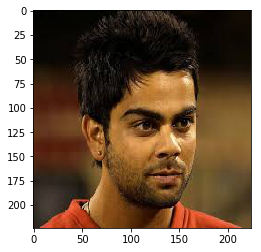

In [215]:
plt.imshow(x_test[106])